In [1]:
# Import dependencies
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# read csv
df = pd.read_csv('./resources/mxmh_survey_results.csv')
df.head()


,Timestamp,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,...,Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects,Permissions
0,8/27/2022 19:29:02,18.0,Spotify,3.0,Yes,Yes,Yes,Latin,Yes,Yes,...,Sometimes,Very frequently,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.
1,8/27/2022 19:57:31,63.0,Pandora,1.5,Yes,No,No,Rock,Yes,No,...,Sometimes,Rarely,Very frequently,Rarely,7.0,2.0,2.0,1.0,NaN,I understand.
2,8/27/2022 21:28:18,18.0,Spotify,4.0,No,No,No,Video game music,No,Yes,...,Never,Rarely,Rarely,Very frequently,7.0,7.0,10.0,2.0,No effect,I understand.
3,8/27/2022 21:40:40,61.0,YouTube Music,2.5,Yes,No,Yes,Jazz,Yes,Yes,...,Sometimes,Never,Never,Never,9.0,7.0,3.0,3.0,Improve,I understand.
4,8/27/2022 21:54:47,18.0,Spotify,4.0,Yes,No,No,R&B,Yes,No,...,Very frequently,Very frequently,Never,Rarely,7.0,2.0,5.0,9.0,Improve,I understand.


## Data discovery

In [3]:
# show all column names
df.columns

Index(['Timestamp', 'Age', 'Primary streaming service', 'Hours per day',
       'While working', 'Instrumentalist', 'Composer', 'Fav genre',
       'Exploratory', 'Foreign languages', 'BPM', 'Frequency [Classical]',
       'Frequency [Country]', 'Frequency [EDM]', 'Frequency [Folk]',
       'Frequency [Gospel]', 'Frequency [Hip hop]', 'Frequency [Jazz]',
       'Frequency [K pop]', 'Frequency [Latin]', 'Frequency [Lofi]',
       'Frequency [Metal]', 'Frequency [Pop]', 'Frequency [R&B]',
       'Frequency [Rap]', 'Frequency [Rock]', 'Frequency [Video game music]',
       'Anxiety', 'Depression', 'Insomnia', 'OCD', 'Music effects',
       'Permissions'],
      dtype='object')

In [4]:
# drop unhelpful columns
cols_to_drop = [
    'Permissions'
    ]

df.drop(columns=cols_to_drop)

,Timestamp,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,...,Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects
0,8/27/2022 19:29:02,18.0,Spotify,3.0,Yes,Yes,Yes,Latin,Yes,Yes,...,Very frequently,Sometimes,Very frequently,Never,Sometimes,3.0,0.0,1.0,0.0,NaN
1,8/27/2022 19:57:31,63.0,Pandora,1.5,Yes,No,No,Rock,Yes,No,...,Sometimes,Sometimes,Rarely,Very frequently,Rarely,7.0,2.0,2.0,1.0,NaN
2,8/27/2022 21:28:18,18.0,Spotify,4.0,No,No,No,Video game music,No,Yes,...,Rarely,Never,Rarely,Rarely,Very frequently,7.0,7.0,10.0,2.0,No effect
3,8/27/2022 21:40:40,61.0,YouTube Music,2.5,Yes,No,Yes,Jazz,Yes,Yes,...,Sometimes,Sometimes,Never,Never,Never,9.0,7.0,3.0,3.0,Improve
4,8/27/2022 21:54:47,18.0,Spotify,4.0,Yes,No,No,R&B,Yes,No,...,Sometimes,Very frequently,Very frequently,Never,Rarely,7.0,2.0,5.0,9.0,Improve
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,10/30/2022 14:37:28,17.0,Spotify,2.0,Yes,Yes,No,Rock,Yes,Yes,...,Very frequently,Never,Rarely,Very frequently,Never,7.0,6.0,0.0,9.0,Improve
732,11/1/2022 22:26:42,18.0,Spotify,1.0,Yes,Yes,No,Pop,Yes,Yes,...,Very frequently,Never,Never,Sometimes,Sometimes,3.0,2.0,2.0,5.0,Improve
733,11/3/2022 23:24:38,19.0,Other streaming service,6.0,Yes,No,Yes,Rap,Yes,No,...,Sometimes,Sometimes,Sometimes,Rarely,Rarely,2.0,2.0,2.0,2.0,Improve
734,11/4/2022 17:31:47,19.0,Spotify,5.0,Yes,Yes,No,Classical,No,No,...,Never,Never,Never,Never,Sometimes,2.0,3.0,2.0,1.0,Improve


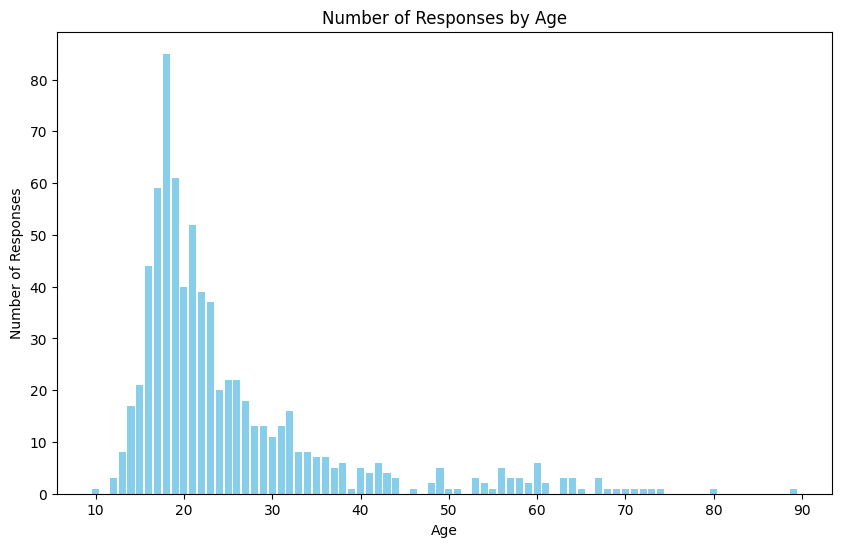

In [6]:
# responses by age
age_counts = df['Age'].value_counts()
age_counts

plt.figure(figsize=(10, 6))  # Adjust the size as needed
plt.bar(age_counts.index, age_counts.values, color='skyblue')
plt.xlabel('Age')
plt.ylabel('Number of Responses')
plt.title('Number of Responses by Age')
plt.xticks(rotation=0)
plt.show()

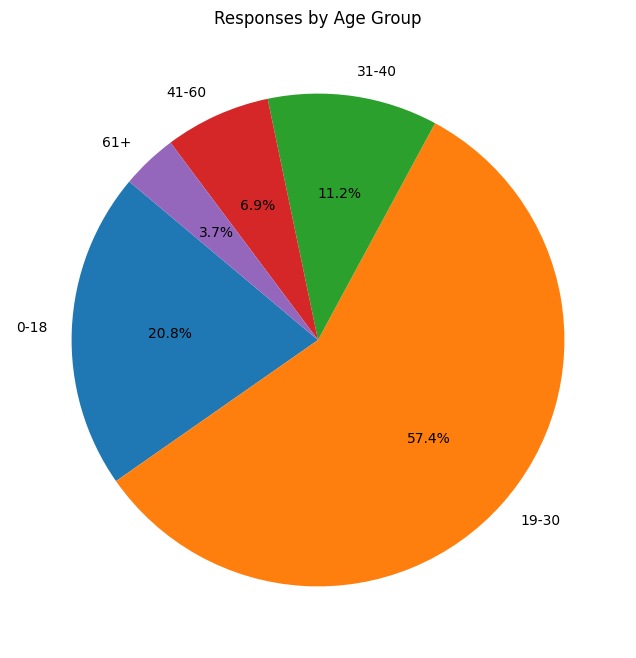

In [28]:
bins =   [0, 18, 30, 40, 60, 90]  # Example age buckets
labels = ['0-18', '19-30', '31-40', '41-60', '61+']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# Step 3: Aggregation
age_group_counts = df['AgeGroup'].value_counts().sort_index()

# Step 4: Plotting
plt.figure(figsize=(10, 8))  # Adjust the size as needed
plt.pie(age_group_counts, labels=age_group_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Responses by Age Group')
plt.show()